In [1]:
# imports
import matplotlib.pyplot as plt
import pandas as pd
import PIDSimulation as pidsim
try:
    import seaborn as sns
except:
    !pip install seaborn
    import seaborn as sns
try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers
except:
    !pip install tensorflow
    import tensorflow as ts
    from tensorflow import keras
    from tensorflow.keras import layers
try:
    from deepevolution import wrap_keras
except:
    !pip install deepevolution
    from deepevolution import wrap_keras
    
wrap_keras()

In [2]:
# read the data
dataset = pd.read_csv("sortedDataTop1.csv")
dataset_copy = dataset.copy()
# split it into 2 pieces - train and test, test being 80% of all
train_dataset = dataset_copy.sample(frac=0.8, random_state=0)
test_dataset = dataset_copy.drop(train_dataset.index)
train_dataset

,Area,Beta,Tp,Proportional,Integral,Derivative
137613,17.0,9.5,0.9,4.0,0.3,2.4
119939,17.0,5.0,0.4,16.0,1.3,0.4
77665,15.0,5.5,0.5,14.0,1.5,0.4
72519,15.0,2.0,1.0,6.0,0.5,1.2
221327,20.0,7.0,0.4,9.0,0.1,1.2
...,...,...,...,...,...,...
197778,19.0,9.0,0.9,10.0,0.5,0.8
15299,9.0,9.0,0.5,7.0,0.7,0.4
166731,18.0,9.5,0.7,13.0,0.7,0.4
55301,14.0,1.5,0.8,15.0,1.5,0.4


In [3]:
# not sure the reason for the code below, it doesn't work as intended
# split features from labels
# warning: run below code only once
# it throws KeyError if argument is already popped

if True:
    train_labels_prop = train_dataset.pop("Proportional")
    train_labels_int = train_dataset.pop("Integral")
    train_labels_der = train_dataset.pop("Derivative")
    data_train = {
        'Proportional': train_labels_prop,
        'Integral': train_labels_int,
        'Derivative': train_labels_der
    }
    train_labels = pd.DataFrame(data_train)
    # same for test
    test_labels_prop = test_dataset.pop("Proportional")
    test_labels_int = test_dataset.pop("Integral")
    test_labels_der = test_dataset.pop("Derivative")
    data_test = {
        'Proportional': test_labels_prop,
        'Integral': test_labels_int,
        'Derivative': test_labels_der
    }
    test_labels = pd.DataFrame(data_test)

train_labels
# test_labels

,Proportional,Integral,Derivative
137613,4.0,0.3,2.4
119939,16.0,1.3,0.4
77665,14.0,1.5,0.4
72519,6.0,0.5,1.2
221327,9.0,0.1,1.2
...,...,...,...
197778,10.0,0.5,0.8
15299,7.0,0.7,0.4
166731,13.0,0.7,0.4
55301,15.0,1.5,0.4


In [4]:
# some statistics about the values
# sns.pairplot(dataset)
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()
# train_stats
train_stats

,count,mean,std,min,25%,50%,75%,max
Area,191786.0,15.926381,3.693254,1.0,14.0,17.0,19.0,20.0
Beta,191786.0,6.080413,2.660454,0.0,4.0,6.5,8.5,9.5
Tp,191786.0,0.549178,0.274814,0.1,0.3,0.5,0.8,1.0


In [5]:
# save the stats from above for denormalization in later use
stats_dir = 'D:\\Dev\\PyCharmProjects\\ISSlab1\\programs\\'
file_stats = open(str(stats_dir) + "GAPID_stats.txt", "w")
# save the mean
# file_stats.write("train_stats['mean'])\n")
sentence = "".join(str(train_stats['mean']) + "\n")
file_stats.write(sentence)
# save the sigma
# file_stats.write("train_stats['std'])\n")
sentence = "".join(str(train_stats['std']) + "\n")
file_stats.write(sentence)
# finish
file_stats.close()
train_stats['mean']

Area    15.926381
Beta     6.080413
Tp       0.549178
Name: mean, dtype: float64

In [6]:
# normalize the data
# here we have 3 columns in x but 6 columns in train stats so we get 3 NaNs
# changed command order to fix it, but previously it was [statistics block] -> [pop labels block]
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']
normed_train_dataset = norm(train_dataset)
normed_test_dataset = norm(test_dataset)
# normed_train_dataset = train_dataset.copy()
# normed_test_dataset = test_dataset.copy()
normed_train_dataset

,Area,Beta,Tp
137613,0.290697,1.285340,1.276579
119939,0.290697,-0.406101,-0.542831
77665,-0.250831,-0.218163,-0.178949
72519,-0.250831,-1.533728,1.640461
221327,1.102989,0.345651,-0.542831
...,...,...,...
197778,0.832225,1.097402,1.276579
15299,-1.875414,1.097402,-0.178949
166731,0.561461,1.285340,0.548815
55301,-0.521595,-1.721666,0.912697


In [7]:
# build the model
inp = keras.Input(3)
layer = layers.Dense(3)(inp)
layer = layers.Dense(12)(layer)
layer = layers.Dense(3)(layer)
model = keras.Model(inp, layer)
model.compile(loss='mse', metrics=['mae', 'mse'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 12        
_________________________________________________________________
dense_1 (Dense)              (None, 12)                48        
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 39        
Total params: 99
Trainable params: 99
Non-trainable params: 0
_________________________________________________________________


In [8]:
# check if everythings connected and no errors are given 
example_batch = normed_train_dataset[:10]
single_example = normed_train_dataset[:1]
single_label = train_labels[:1]
print(single_example)
print(single_label)
example_result = model.predict(example_batch)
example_result

            Area     Beta        Tp
137613  0.290697  1.28534  1.276579
        Proportional  Integral  Derivative
137613           4.0       0.3         2.4


array([[ 0.0201031 , -0.22196774, -0.5050521 ],
       [-0.29886323,  0.05928773, -0.08846264],
       [ 0.13260081,  0.04601061,  0.2173932 ],
       [ 1.5182934 ,  0.02728176,  0.44842887],
       [-1.0370466 , -0.05111544, -0.7855576 ],
       [-1.2398639 , -0.07659042, -0.6206879 ],
       [-0.34469062, -0.1922827 , -0.7704314 ],
       [-0.41897628, -0.11485807, -0.77646136],
       [ 0.6012964 ,  0.11453079,  1.0388815 ],
       [-0.78938246, -0.03767563, -0.46924177]], dtype=float32)

In [9]:
# fitness function
def fitness_func(model, X, Y):
    value = model.evaluate(X, Y, batch_size=2048, verbose=0)[0]
    value = 1 / value * 1000
    return value
print(fitness_func(model, single_example, single_label))
# retruns [loss_value(mse) and metrics] so for ours it's:
# retrurn [mse, mae, mse]

122.19284187131561


[Generation 1 / 500] score: 14.9823 (best: 15.0084; std: 0.0251)
[Generation 2 / 500] score: 15.0707 (best: 15.1309; std: 0.0522)
[Generation 3 / 500] score: 15.1615 (best: 15.283; std: 0.1094)
[Generation 4 / 500] score: 15.2806 (best: 15.2908; std: 0.0116)
[Generation 5 / 500] score: 15.3426 (best: 15.3944; std: 0.0518)
[Generation 6 / 500] score: 15.3919 (best: 15.402; std: 0.0116)
[Generation 7 / 500] score: 15.4318 (best: 15.4418; std: 0.0087)
[Generation 8 / 500] score: 15.4698 (best: 15.4992; std: 0.0287)
[Generation 9 / 500] score: 15.5274 (best: 15.6063; std: 0.0692)
[Generation 10 / 500] score: 15.6109 (best: 15.6225; std: 0.0101)
[Generation 11 / 500] score: 15.6452 (best: 15.6539; std: 0.0075)
[Generation 12 / 500] score: 15.6916 (best: 15.7156; std: 0.023)
[Generation 13 / 500] score: 15.7376 (best: 15.7757; std: 0.0332)
[Generation 14 / 500] score: 15.7872 (best: 15.816; std: 0.0252)
[Generation 15 / 500] score: 15.8202 (best: 15.8277; std: 0.0065)
[Generation 16 / 500] s

[Generation 126 / 500] score: 28.985 (best: 29.1046; std: 0.1069)
[Generation 127 / 500] score: 29.2069 (best: 29.2745; std: 0.0674)
[Generation 128 / 500] score: 29.3698 (best: 29.4348; std: 0.0843)
[Generation 129 / 500] score: 29.5003 (best: 29.5167; std: 0.0156)
[Generation 130 / 500] score: 29.8373 (best: 30.0891; std: 0.2385)
[Generation 131 / 500] score: 30.0756 (best: 30.0891; std: 0.0233)
[Generation 132 / 500] score: 30.1605 (best: 30.2084; std: 0.0484)
[Generation 133 / 500] score: 30.4706 (best: 30.9005; std: 0.3753)
[Generation 134 / 500] score: 30.842 (best: 30.9005; std: 0.0961)
[Generation 135 / 500] score: 31.1723 (best: 31.4736; std: 0.2728)
[Generation 136 / 500] score: 31.326 (best: 31.4736; std: 0.1285)
[Generation 137 / 500] score: 31.4624 (best: 31.6191; std: 0.1625)
[Generation 138 / 500] score: 31.7978 (best: 32.0034; std: 0.1935)
[Generation 139 / 500] score: 32.1647 (best: 32.3937; std: 0.1998)
[Generation 140 / 500] score: 32.2922 (best: 32.3937; std: 0.0879

[Generation 248 / 500] score: 176.4512 (best: 176.8612; std: 0.3919)
[Generation 249 / 500] score: 178.1376 (best: 179.3347; std: 1.2387)
[Generation 250 / 500] score: 178.6366 (best: 179.3347; std: 0.6087)
[Generation 251 / 500] score: 180.1041 (best: 180.8333; std: 0.6527)
[Generation 252 / 500] score: 181.1139 (best: 181.672; std: 0.4833)
[Generation 253 / 500] score: 181.8443 (best: 182.3069; std: 0.4049)
[Generation 254 / 500] score: 182.96 (best: 183.8782; std: 0.8185)
[Generation 255 / 500] score: 183.3929 (best: 183.8782; std: 0.5702)
[Generation 256 / 500] score: 184.0975 (best: 184.2283; std: 0.1911)
[Generation 257 / 500] score: 185.0326 (best: 185.5232; std: 0.4249)
[Generation 258 / 500] score: 185.4698 (best: 185.9347; std: 0.4938)
[Generation 259 / 500] score: 186.7455 (best: 186.9978; std: 0.2186)
[Generation 260 / 500] score: 187.09 (best: 187.1399; std: 0.08)
[Generation 261 / 500] score: 188.5356 (best: 189.1225; std: 0.7929)
[Generation 262 / 500] score: 188.9289 (b

[Generation 368 / 500] score: 201.9613 (best: 201.9979; std: 0.0317)
[Generation 369 / 500] score: 201.9613 (best: 201.9979; std: 0.0317)
[Generation 370 / 500] score: 201.9613 (best: 201.9979; std: 0.0317)
[Generation 371 / 500] score: 201.9613 (best: 201.9979; std: 0.0317)
[Generation 372 / 500] score: 201.9613 (best: 201.9979; std: 0.0317)
[Generation 373 / 500] score: 201.9613 (best: 201.9979; std: 0.0317)
[Generation 374 / 500] score: 201.9613 (best: 201.9979; std: 0.0317)
[Generation 375 / 500] score: 201.9613 (best: 201.9979; std: 0.0317)
[Generation 376 / 500] score: 201.9613 (best: 201.9979; std: 0.0317)
[Generation 377 / 500] score: 201.9613 (best: 201.9979; std: 0.0317)
[Generation 378 / 500] score: 201.9613 (best: 201.9979; std: 0.0317)
[Generation 379 / 500] score: 201.9613 (best: 201.9979; std: 0.0317)
[Generation 380 / 500] score: 201.9613 (best: 201.9979; std: 0.0317)
[Generation 381 / 500] score: 201.9613 (best: 201.9979; std: 0.0317)
[Generation 382 / 500] score: 201.

[Generation 487 / 500] score: 202.2482 (best: 202.2659; std: 0.0166)
[Generation 488 / 500] score: 202.2482 (best: 202.2659; std: 0.0166)
[Generation 489 / 500] score: 202.2482 (best: 202.2659; std: 0.0166)
[Generation 490 / 500] score: 202.2482 (best: 202.2659; std: 0.0166)
[Generation 491 / 500] score: 202.2616 (best: 202.2733; std: 0.0143)
[Generation 492 / 500] score: 202.2616 (best: 202.2733; std: 0.0143)
[Generation 493 / 500] score: 202.2616 (best: 202.2733; std: 0.0143)
[Generation 494 / 500] score: 202.2616 (best: 202.2733; std: 0.0143)
[Generation 495 / 500] score: 202.2616 (best: 202.2733; std: 0.0143)
[Generation 496 / 500] score: 202.2616 (best: 202.2733; std: 0.0143)
[Generation 497 / 500] score: 202.2616 (best: 202.2733; std: 0.0143)
[Generation 498 / 500] score: 202.2616 (best: 202.2733; std: 0.0143)
[Generation 499 / 500] score: 202.2616 (best: 202.2733; std: 0.0143)
[Generation 500 / 500] score: 202.2816 (best: 202.3057; std: 0.0211)
24/24 [===========================

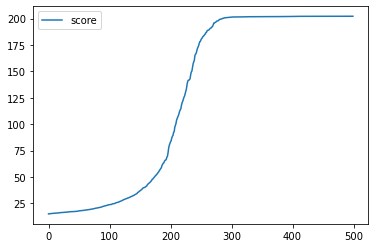

In [10]:
# train the model
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0:
            print('')
        print('.',end='')

# number of 
EPOCHS = 1000

# early stop in case we start overfitting
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# fit the model
maxgen = 500 # maxgen = 1000 was the previous one, around 500 we already have ok values
# Evolve the model
history = model.fit_evolve(normed_train_dataset, train_labels, max_generations=maxgen, population=100, top_k=3, fitness_func=fitness_func)

print(f"Model accuracy: {model.evaluate(normed_test_dataset, test_labels, batch_size=2048)[0]}")

# indicate fitting finished
print('\n' + 'Fitting done')

# show history
pd.DataFrame(history).plot()
plt.show()

In [11]:
# demonstrate by predicting a set of values
d = {'Area':[25],'Beta':[2.5],'Tp':[0.1]}
demo_values = pd.DataFrame(d)
print(demo_values)
# print(type(demo_values))
print('Expected output: \n11, 4.7, 0.4\nRecieved:\n')
pred = model.predict(norm(demo_values))
pred

   Area  Beta   Tp
0    25   2.5  0.1
Expected output: 
11, 4.7, 0.4
Recieved:



array([[20.73087  ,  0.7766812,  0.8241637]], dtype=float32)

In [12]:
# save the model
import tempfile
import os

# export path
# model_dir = tempfile.gettempdir()
model_dir = 'D:\\Dev\\PyCharmProjects\\ISSlab1\\programs\\saved models'
# model_dir returns 'C:\\Users\\Hubert\\AppData\\Local\\Temp'
version = "version-ga-pid"
export_path = os.path.join(model_dir, version)

# saving
tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

INFO:tensorflow:Assets written to: D:\Dev\PyCharmProjects\ISSlab1\programs\saved models\version-ga-pid\assets
